<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/p_delta/cant_col_p_delta.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

# Rectangular Concrete Shear Wall Neutral Axis

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../assets/modules/"))
from materials import Concrete, BilinearSteel
from shapes import Rectangle, Circle
from concrete import *
from steel import RebarSection

In [2]:
# Define rebar material with fy = 60 ksi
a706_60 = BilinearSteel(name='A706 Gr.60', fy=60, fu=80, alpha=0.0) # A706 Gr. 60 low-alloy steel

# Define rebar sections
r_11 = RebarSection(size=11, bar_mat=a706_60) # No. 11 rebar
r_8 = RebarSection(size=8, bar_mat=a706_60) # No. 8 rebar

# Define concrete material with f'c = 5000 psi
c_5000 = ACIConcrete(fc=5000)

# Define shear wall cross-section (20" x 366")
rect_366x20 = Rectangle(width=366, height=20)

# Define shear wall secion
c_sec = RectangleWall(shape=rect_366x20, concrete_mat=c_5000, cover=1.5)

<Axes: >

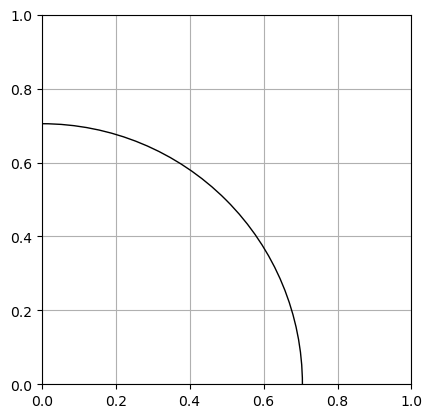

In [3]:
r_11.plot()

<Axes: >

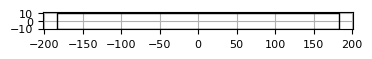

In [4]:
c_sec.shape.plot()

In [5]:
# Add rebar to the shear wall section
c_sec.add_rebar_row(r_11, center=(-180, 7), n=7, spacing=9)
c_sec.add_rebar_row(r_11, center=(-180, -7), n=7, spacing=9)
c_sec.add_rebar(r_11, center=(-180, 0))

c_sec.add_rebar_row(r_8, center=(0, 7), n=14, spacing=9)
c_sec.add_rebar_row(r_8, center=(0, -7), n=14, spacing=9)
c_sec.add_rebar_row(r_8, center=(-9, 7), n=13, spacing=9, reverse=True)
c_sec.add_rebar_row(r_8, center=(-9, -7), n=13, spacing=9, reverse=True)

c_sec.add_rebar_row(r_11, center=(180, 7), n=7, spacing=9, reverse=True)
c_sec.add_rebar_row(r_11, center=(180, -7), n=7, spacing=9, reverse=True)
c_sec.add_rebar(r_11, center=(180, 0))


<Axes: >

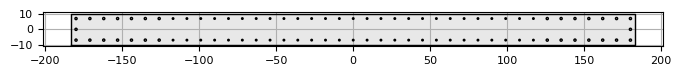

In [6]:
c_sec.plot()

In [7]:
y_neutral = 190
curvature = c_sec.mat.eps_cu / y_neutral

y_bar, bar_strain, bar_stress, bar_force = get_rebar_forces(concrete_sec=c_sec, curvature=curvature, y_neutral=y_neutral)
y_con, con_strain, con_stress, con_force = get_rect_concrete_force(concrete_sec=c_sec, curvature=curvature, y_neutral=y_neutral)

In [8]:
print(con_strain.min())
print(con_stress.min())

-0.0027789473684210527
-4250.0


In [9]:
con_strain[:20]

array([[-0.00277895],
       [-0.00272057],
       [-0.0026622 ],
       [-0.00260383],
       [-0.00254545],
       [-0.00248708],
       [-0.00242871],
       [-0.00237033],
       [-0.00231196],
       [-0.00225359],
       [-0.00219522],
       [-0.00213684],
       [-0.00207847],
       [-0.0020201 ],
       [-0.00196172],
       [-0.00190335],
       [-0.00184498],
       [-0.0017866 ],
       [-0.00172823],
       [-0.00166986]])

In [10]:
con_stress[:20]

array([[-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.],
       [-4250.]])

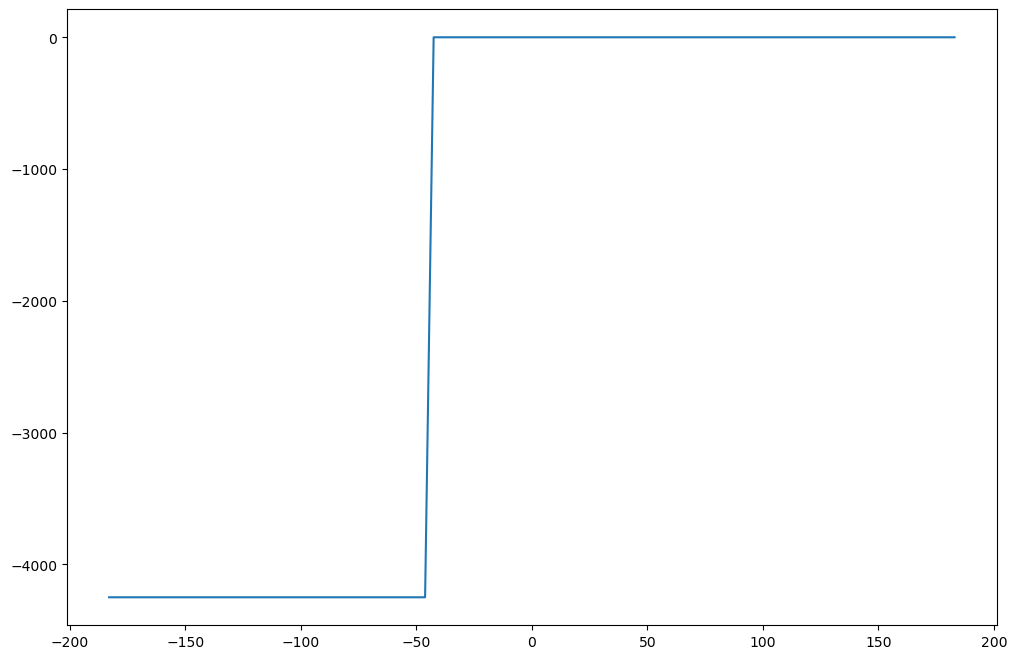

In [11]:
plt.figure(figsize=(12, 8))
# plt.scatter(y_bar, bar_stress)
plt.plot(y_con, con_stress)
plt.show()

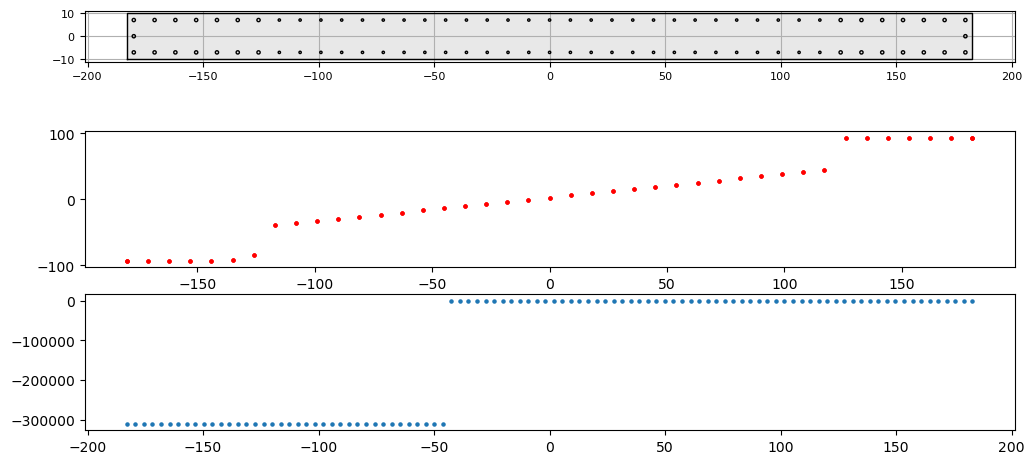

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0] = c_sec.plot(ax=ax[0])
ax[1].scatter(y_bar, bar_force, s=5, color='red', label='Rebar Stress')
ax[2].scatter(y_con, con_force, s=5, label='Concrete Stress')
plt.show()